# Part IV. Data Pre-processing

Before we feed the data to our detection and inference models, several data-processing procedures are applied beforehand.

For detection model, a few data augmentation techniques are used to increase model's generalizability and prevent overfitting. The applied measures include:

1. Random Flip (Randomly flipping one pixel)
2. Random Scaling (Scale image to a random size)
3. Normalization (Normalize RGB value according to their mean and standard deviation of each channel)
4. Photo Metric Distortion (Use random brightness, hue and saturation)

Due to GPU memory constraint, images are also cropped into size of 512x512.


# Part V. Proposed Method


## Detection

Since our goal is to infer and improve detection results using language models, we would like our detection accuracy to be as high as possible in the first place. We employ an Cascade RCNN with HRNet backbone model from <a href="https://github.com/tascj/kaggle-kuzushiji-recognition">the current number one solution</a> to generate detection results.

Please download using the following command:

<code>git clone https://github.com/tascj/kaggle-kuzushiji-recognition</code>

After that, please follow the setup and reproduce guide in their readme.md. The training takes roughly 2 days with 2 gpus.

Here is a brief introduction of the chosen detection model:

<img style="width: 500px; left:0" src="https://pic3.zhimg.com/v2-09c939dc605941bbc66c3ba5935301bc_1200x500.jpg"></img>
<div style="width:500px; margin: auto; text-align:center">Figure 1. Cascade-RCNN Structure</div>

Cascade-RCNN is a multi-stage object detection model. In object detection, when determining IoU threshold, if we use a low threshold, the bounding box may include a lot of background and tend to be very noisy. However, if we raise the threshold, the model may be overfitted to the dataset. Hence, to counter this issue. Cascaded-RCNN trains different IoU threshold at different stages in a low-to-high order and it feeds output from low IOU detector to high IoU detector based on a progressively improved hypothesis (The output of a detector is a good distribution of next high-quality detector).

<img style="width: 500px; left:0" src="https://jingdongwang2017.github.io/Projects/HRNet/images/HRNet.jpg"></img>
<div style="width:500px; margin: auto; text-align:center">Figure 2. HRNet Structure</div>

HRNet stands for High-resolution network. It is used to learn high-resolution representation. Unlike most of current models which obtains high-resolution features by feeding inputs through high-to-low and low-to-high sub-networks sequentially, HRNet maintains high-resolution representations throughout the stages. It uses the high-resolution network as the first stage and gradually add high-to-low resolution subnetworks in following stages. Those networks are connected in parallel in contrast to sequential connection in current methods. A repeated multi-scale fusion technique is used so that each high-to-low representation receives information from other scale representation and this would lead to a rich high-resolution representation.

After training the model, we can use an inference script to verify the detection results.

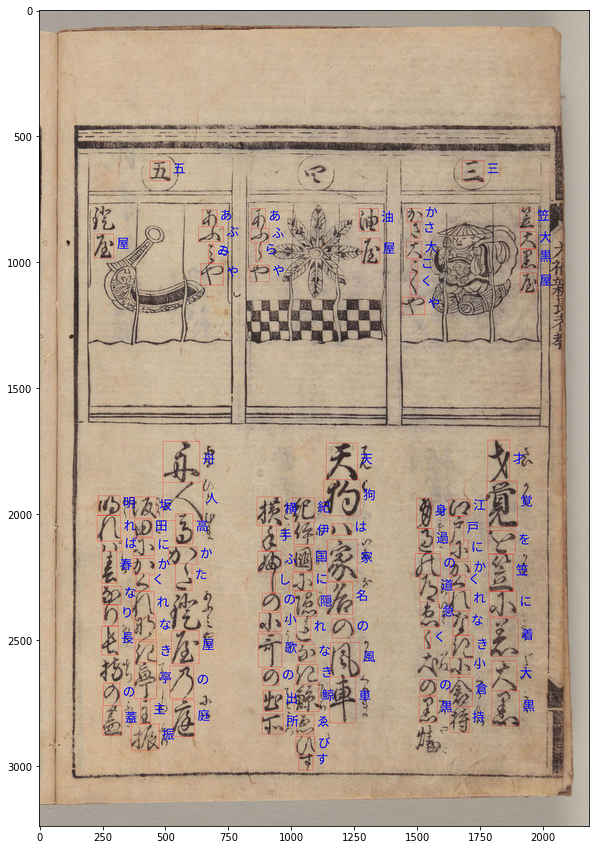

In [12]:
from mmdet.apis import init_detector, inference_detector, show_result
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

CLASS_NAMES = 'U+0031 U+0032 U+0034 U+0036 U+0039 U+003F U+2000B U+20D45 U+2123D U+22999 U+22CE3 U+231C3 U+2324A U+233D0 U+23D0E U+241C6 U+242CE U+2437D U+24E30 U+24E60 U+24FA3 U+2564A U+25750 U+25877 U+25A0 U+25A1 U+25B2 U+25B3 U+25CB U+25CF U+25DA1 U+25E2E U+25EF U+25FFB U+264B3 U+266B0 U+27752 U+28263 U+29780 U+29DDA U+29E75 U+3002 U+3005 U+3006 U+3007 U+300C U+300D U+3031 U+3032 U+303B U+303D U+3042 U+3044 U+3046 U+3048 U+304A U+304B U+304C U+304D U+304E U+304F U+3050 U+3051 U+3052 U+3053 U+3054 U+3055 U+3056 U+3057 U+3058 U+3059 U+305A U+305B U+305C U+305D U+305E U+305F U+3060 U+3061 U+3062 U+3063 U+3064 U+3065 U+3066 U+3067 U+3068 U+3069 U+306A U+306B U+306C U+306D U+306E U+306F U+3070 U+3071 U+3072 U+3073 U+3074 U+3075 U+3076 U+3077 U+3078 U+3079 U+307A U+307B U+307C U+307D U+307E U+307F U+3080 U+3081 U+3082 U+3083 U+3084 U+3085 U+3086 U+3087 U+3088 U+3089 U+308A U+308B U+308C U+308D U+308F U+3090 U+3091 U+3092 U+3093 U+309D U+309E U+309F U+30A1 U+30A2 U+30A3 U+30A4 U+30A6 U+30A8 U+30AA U+30AB U+30AC U+30AD U+30AE U+30AF U+30B0 U+30B1 U+30B2 U+30B3 U+30B4 U+30B5 U+30B6 U+30B7 U+30B8 U+30B9 U+30BA U+30BB U+30BC U+30BD U+30BF U+30C0 U+30C1 U+30C2 U+30C3 U+30C4 U+30C5 U+30C6 U+30C7 U+30C8 U+30C9 U+30CA U+30CB U+30CC U+30CD U+30CE U+30CF U+30D0 U+30D1 U+30D2 U+30D3 U+30D4 U+30D5 U+30D6 U+30D7 U+30D8 U+30D9 U+30DA U+30DB U+30DC U+30DD U+30DE U+30DF U+30E0 U+30E1 U+30E2 U+30E4 U+30E6 U+30E7 U+30E8 U+30E9 U+30EA U+30EB U+30EC U+30ED U+30EF U+30F1 U+30F2 U+30F3 U+30F6 U+30FB U+30FC U+30FD U+30FE U+3280 U+3281 U+3282 U+3283 U+3284 U+3402 U+342B U+3479 U+34B5 U+34DB U+351F U+352B U+353A U+355D U+35A7 U+3634 U+3691 U+3761 U+3836 U+384C U+3863 U+38F2 U+3919 U+3AD6 U+3B87 U+3C55 U+4093 U+43E3 U+43FB U+4408 U+4453 U+4543 U+4572 U+4C61 U+4C99 U+4E00 U+4E01 U+4E03 U+4E07 U+4E08 U+4E09 U+4E0A U+4E0B U+4E0D U+4E0E U+4E11 U+4E12 U+4E14 U+4E16 U+4E17 U+4E18 U+4E19 U+4E1E U+4E21 U+4E24 U+4E26 U+4E2A U+4E2D U+4E31 U+4E32 U+4E38 U+4E39 U+4E3B U+4E3C U+4E42 U+4E43 U+4E45 U+4E4B U+4E4D U+4E4E U+4E4F U+4E57 U+4E58 U+4E59 U+4E5D U+4E5E U+4E5F U+4E71 U+4E73 U+4E7E U+4E80 U+4E82 U+4E86 U+4E88 U+4E89 U+4E8B U+4E8C U+4E8D U+4E8E U+4E91 U+4E92 U+4E94 U+4E95 U+4E98 U+4E99 U+4E9B U+4EA1 U+4EA4 U+4EA5 U+4EA6 U+4EA8 U+4EAB U+4EAC U+4EAD U+4EAE U+4EBA U+4EC0 U+4EC1 U+4EC2 U+4EC6 U+4EC7 U+4ECA U+4ECB U+4ECD U+4ECF U+4ED4 U+4ED5 U+4ED6 U+4ED7 U+4ED8 U+4ED9 U+4EDD U+4EE3 U+4EE4 U+4EE5 U+4EED U+4EEE U+4EF0 U+4EF2 U+4EF6 U+4EFB U+4F07 U+4F09 U+4F0A U+4F0D U+4F0F U+4F10 U+4F11 U+4F1A U+4F1D U+4F2F U+4F31 U+4F34 U+4F38 U+4F3A U+4F3C U+4F3D U+4F40 U+4F46 U+4F47 U+4F4D U+4F4E U+4F4F U+4F50 U+4F53 U+4F55 U+4F57 U+4F59 U+4F5B U+4F5C U+4F5E U+4F69 U+4F73 U+4F75 U+4F76 U+4F7F U+4F86 U+4F8B U+4F8D U+4F98 U+4F9B U+4F9D U+4FA0 U+4FA1 U+4FAB U+4FAD U+4FAE U+4FAF U+4FB2 U+4FBF U+4FC2 U+4FC3 U+4FC4 U+4FCA U+4FCE U+4FD7 U+4FD8 U+4FDA U+4FDD U+4FDF U+4FE0 U+4FE1 U+4FE4 U+4FEE U+4FEF U+4FF1 U+4FF3 U+4FF5 U+4FF8 U+4FFA U+5009 U+500B U+500D U+500F U+5011 U+5012 U+5016 U+5018 U+5019 U+501A U+501F U+5023 U+5024 U+5026 U+5029 U+502B U+502D U+5030 U+5036 U+5039 U+5047 U+5048 U+504F U+5055 U+5056 U+505A U+505C U+5065 U+5074 U+5076 U+5078 U+507D U+5080 U+5085 U+508D U+5091 U+5098 U+5099 U+509A U+50AC U+50AD U+50B2 U+50B3 U+50B5 U+50B7 U+50BE U+50C2 U+50C5 U+50C9 U+50CD U+50CF U+50D1 U+50D5 U+50DC U+50DE U+50E5 U+50E7 U+50EE U+50F5 U+50F9 U+50FB U+5100 U+5104 U+5109 U+5112 U+5118 U+5121 U+512A U+5132 U+5140 U+5141 U+5143 U+5144 U+5145 U+5146 U+5147 U+5148 U+5149 U+514A U+514B U+514C U+514D U+514E U+5150 U+5152 U+515A U+515C U+5165 U+5168 U+5169 U+516A U+516B U+516C U+516D U+516E U+5171 U+5175 U+5176 U+5177 U+5178 U+517C U+5185 U+5186 U+5189 U+518A U+518C U+518D U+5191 U+5199 U+519D U+51A0 U+51A4 U+51A5 U+51A8 U+51A9 U+51AC U+51B0 U+51B3 U+51B4 U+51B5 U+51B6 U+51B7 U+51C4 U+51C6 U+51C9 U+51CB U+51CC U+51CD U+51CF U+51DD U+51E0 U+51E1 U+51E2 U+51E6 U+51E7 U+51E9 U+51F0 U+51F6 U+51F9 U+51FA U+5200 U+5203 U+5204 U+5205 U+5206 U+5207 U+5208 U+520A U+520E U+5211 U+5215 U+5217 U+521D U+5224 U+5225 U+5227 U+5229 U+522A U+5230 U+5236 U+5237 U+5239 U+523A U+523B U+5243 U+5244 U+5247 U+524A U+524B U+524D U+5256 U+525B U+5263 U+5264 U+5265 U+5269 U+526A U+526F U+5270 U+5271 U+5272 U+5275 U+5284 U+5287 U+5289 U+528D U+5292 U+5294 U+529B U+529F U+52A0 U+52A3 U+52A9 U+52AA U+52AB U+52B1 U+52B4 U+52B9 U+52C3 U+52C5 U+52C7 U+52C9 U+52D5 U+52D8 U+52D9 U+52DD U+52DE U+52DF U+52E2 U+52E4 U+52E6 U+52E7 U+52F2 U+52F3 U+52F5 U+52F8 U+52FA U+52FE U+52FF U+5301 U+5302 U+5305 U+5306 U+5315 U+5316 U+5317 U+5319 U+531C U+5320 U+5323 U+5339 U+533B U+533F U+5340 U+5341 U+5343 U+5344 U+5345 U+5347 U+5348 U+534A U+5351 U+5352 U+5353 U+5354 U+5357 U+5358 U+535A U+535C U+5360 U+5365 U+5366 U+5367 U+5369 U+536F U+5370 U+5371 U+5373 U+5374 U+5375 U+5377 U+5378 U+537F U+5382 U+5384 U+5398 U+539A U+539F U+53A0 U+53A8 U+53AD U+53B3 U+53BB U+53C2 U+53C3 U+53C8 U+53C9 U+53CA U+53CB U+53CC U+53CD U+53CE U+53D4 U+53D6 U+53D7 U+53D9 U+53DB U+53DF U+53E1 U+53E2 U+53E3 U+53E4 U+53E5 U+53E9 U+53EA U+53EB U+53EC U+53EE U+53EF U+53F0 U+53F1 U+53F2 U+53F3 U+53F6 U+53F7 U+53F8 U+5401 U+5403 U+5404 U+5408 U+5409 U+540A U+540C U+540D U+540E U+540F U+5410 U+5411 U+541B U+541D U+541F U+5420 U+5426 U+542B U+542D U+542E U+5436 U+5438 U+5439 U+543B U+543C U+543E U+5440 U+5442 U+5446 U+5448 U+5449 U+544A U+5451 U+545F U+5468 U+546A U+5473 U+5475 U+547C U+547D U+5480 U+5484 U+548B U+548C U+548E U+5492 U+54A5 U+54A8 U+54AB U+54AC U+54B2 U+54B3 U+54B8 U+54BD U+54C0 U+54C1 U+54C9 U+54E1 U+54E2 U+54E5 U+54E9 U+54ED U+54EE U+54F2 U+54FD U+5504 U+5507 U+5510 U+5516 U+552F U+5531 U+553E U+5541 U+5544 U+5546 U+554C U+554F U+5553 U+5556 U+5557 U+555C U+557B U+557C U+5583 U+5584 U+5589 U+558A U+558B U+5598 U+559A U+559C U+559D U+559E U+559F U+55A7 U+55A9 U+55AA U+55AB U+55AE U+55B0 U+55B6 U+55BB U+55C5 U+55C7 U+55D4 U+55DA U+55DC U+55DF U+55E3 U+55FD U+5606 U+5608 U+5609 U+5617 U+5618 U+5629 U+562F U+5632 U+5638 U+563B U+5640 U+5642 U+564C U+564E U+5650 U+5653 U+5668 U+566A U+566B U+566C U+5672 U+5674 U+567A U+5680 U+56A2 U+56AE U+56B4 U+56BC U+56C0 U+56C1 U+56C2 U+56C3 U+56C9 U+56CA U+56D3 U+56D8 U+56DA U+56DB U+56DE U+56E0 U+56E3 U+56EC U+56F0 U+56F2 U+56F3 U+56FA U+56FD U+56FF U+5703 U+5709 U+570B U+570D U+5711 U+5712 U+5713 U+5716 U+5718 U+571F U+5721 U+5728 U+572D U+5730 U+5742 U+5747 U+574A U+574F U+5750 U+5751 U+5761 U+5764 U+5766 U+576A U+5782 U+57A2 U+57A3 U+57A8 U+57C0 U+57C3 U+57CB U+57CE U+57D2 U+57D3 U+57D4 U+57DC U+57DF U+57F5 U+57F7 U+57FA U+5800 U+5802 U+5805 U+5806 U+5815 U+5824 U+582A U+582F U+5830 U+5831 U+5834 U+5835 U+583A U+5840 U+584A U+5852 U+5854 U+5857 U+585A U+585E U+5869 U+5872 U+5875 U+5883 U+5885 U+5893 U+5897 U+589C U+58A8 U+58AE U+58BE U+58C1 U+58C7 U+58CA U+58CC U+58D1 U+58D2 U+58DC U+58DE U+58DF U+58E4 U+58EB U+58EC U+58EE U+58EF U+58F0 U+58F1 U+58F2 U+58F3 U+58F7 U+58F9 U+58FA U+58FB U+58FC U+58FD U+5900 U+5909 U+590F U+5915 U+5916 U+5919 U+591A U+591B U+591C U+5922 U+5925 U+5927 U+5929 U+592A U+592B U+592D U+592E U+592F U+5931 U+5937 U+593E U+5947 U+5948 U+5949 U+594F U+5951 U+5954 U+5955 U+595A U+5960 U+5962 U+5965 U+5967 U+596A U+596E U+5973 U+5974 U+5978 U+597D U+5982 U+5983 U+5984 U+598A U+5993 U+5996 U+5999 U+59A3 U+59A4 U+59A8 U+59AC U+59B9 U+59BB U+59BE U+59C9 U+59CA U+59CB U+59D1 U+59D2 U+59D3 U+59D4 U+59DA U+59DC U+59E5 U+59E6 U+59E8 U+59EA U+59EB U+59FB U+59FF U+5A01 U+5A0C U+5A11 U+5A18 U+5A1F U+5A23 U+5A25 U+5A2F U+5A35 U+5A36 U+5A3C U+5A46 U+5A49 U+5A55 U+5A5A U+5A62 U+5A66 U+5A6A U+5A6C U+5A7F U+5A92 U+5A9A U+5A9B U+5AB1 U+5AB3 U+5AB5 U+5ABD U+5AC1 U+5AC9 U+5ACC U+5AD7 U+5AE1 U+5AE6 U+5AE9 U+5AF0 U+5AF5 U+5B09 U+5B0B U+5B16 U+5B22 U+5B2C U+5B30 U+5B32 U+5B36 U+5B40 U+5B41 U+5B43 U+5B50 U+5B51 U+5B54 U+5B55 U+5B57 U+5B58 U+5B5C U+5B5D U+5B5F U+5B63 U+5B64 U+5B66 U+5B69 U+5B6B U+5B70 U+5B78 U+5B85 U+5B87 U+5B88 U+5B89 U+5B8B U+5B8C U+5B8D U+5B8F U+5B95 U+5B97 U+5B98 U+5B99 U+5B9A U+5B9B U+5B9C U+5B9D U+5B9F U+5BA2 U+5BA3 U+5BA4 U+5BA5 U+5BA6 U+5BAE U+5BB0 U+5BB3 U+5BB4 U+5BB5 U+5BB6 U+5BB8 U+5BB9 U+5BBF U+5BC2 U+5BC3 U+5BC4 U+5BC5 U+5BC6 U+5BC7 U+5BCC U+5BD0 U+5BD2 U+5BD3 U+5BD4 U+5BDB U+5BDD U+5BDE U+5BDF U+5BE1 U+5BE2 U+5BE4 U+5BE6 U+5BE7 U+5BE8 U+5BE9 U+5BEB U+5BEE U+5BF3 U+5BF5 U+5BF6 U+5BF8 U+5BFA U+5BFE U+5BFF U+5C01 U+5C02 U+5C04 U+5C05 U+5C06 U+5C07 U+5C08 U+5C09 U+5C0A U+5C0B U+5C0D U+5C0E U+5C0F U+5C11 U+5C13 U+5C16 U+5C1A U+5C20 U+5C22 U+5C24 U+5C28 U+5C2D U+5C31 U+5C39 U+5C3A U+5C3B U+5C3C U+5C3D U+5C3E U+5C3F U+5C40 U+5C41 U+5C45 U+5C46 U+5C48 U+5C4A U+5C4B U+5C4D U+5C4E U+5C4F U+5C50 U+5C51 U+5C53 U+5C55 U+5C5B U+5C5E U+5C60 U+5C61 U+5C62 U+5C65 U+5C69 U+5C6C U+5C6F U+5C71 U+5C8C U+5C90 U+5C91 U+5CA1 U+5CA8 U+5CA9 U+5CB1 U+5CB3 U+5CB8 U+5CD9 U+5CE0 U+5CE8 U+5CEF U+5CF0 U+5CF6 U+5CFD U+5D07 U+5D0E U+5D11 U+5D14 U+5D16 U+5D19 U+5D29 U+5D50 U+5D5C U+5D69 U+5D6F U+5D8B U+5D8C U+5DAE U+5DBA U+5DBC U+5DBD U+5DCC U+5DD6 U+5DDD U+5DDE U+5DE1 U+5DE2 U+5DE3 U+5DE5 U+5DE6 U+5DE7 U+5DE8 U+5DEB U+5DEE U+5DF1 U+5DF2 U+5DF3 U+5DF4 U+5DF5 U+5DF7 U+5DFB U+5DFE U+5E02 U+5E03 U+5E06 U+5E0B U+5E0C U+5E16 U+5E19 U+5E1B U+5E1D U+5E25 U+5E2B U+5E2D U+5E2F U+5E30 U+5E33 U+5E36 U+5E37 U+5E38 U+5E3D U+5E45 U+5E47 U+5E55 U+5E5F U+5E61 U+5E62 U+5E63 U+5E72 U+5E73 U+5E74 U+5E76 U+5E77 U+5E78 U+5E7B U+5E7C U+5E7D U+5E7E U+5E7F U+5E81 U+5E83 U+5E84 U+5E87 U+5E8A U+5E8F U+5E95 U+5E96 U+5E97 U+5E9A U+5E9C U+5EA6 U+5EA7 U+5EAB U+5EAD U+5EB5 U+5EB6 U+5EB7 U+5EB8 U+5EBB U+5EC3 U+5EC8 U+5EC9 U+5ECA U+5ED3 U+5EDF U+5EE2 U+5EE3 U+5EE9 U+5EEA U+5EF0 U+5EF1 U+5EF3 U+5EF6 U+5EF7 U+5EFA U+5EFB U+5EFC U+5EFD U+5EFE U+5EFF U+5F01 U+5F04 U+5F09 U+5F0F U+5F10 U+5F11 U+5F13 U+5F14 U+5F15 U+5F16 U+5F17 U+5F18 U+5F1F U+5F25 U+5F26 U+5F27 U+5F2F U+5F31 U+5F35 U+5F37 U+5F3A U+5F3E U+5F42 U+5F48 U+5F4A U+5F4C U+5F4E U+5F53 U+5F59 U+5F62 U+5F66 U+5F69 U+5F6B U+5F6D U+5F70 U+5F71 U+5F73 U+5F77 U+5F79 U+5F7C U+5F7F U+5F80 U+5F81 U+5F82 U+5F83 U+5F84 U+5F85 U+5F89 U+5F8A U+5F8B U+5F8C U+5F90 U+5F91 U+5F92 U+5F93 U+5F97 U+5F98 U+5F9C U+5F9E U+5FA0 U+5FA1 U+5FA4 U+5FA8 U+5FA9 U+5FAE U+5FB3 U+5FB7 U+5FB9 U+5FBD U+5FC3 U+5FC5 U+5FCC U+5FCD U+5FD7 U+5FD8 U+5FD9 U+5FDC U+5FDD U+5FE0 U+5FEB U+5FF0 U+5FF5 U+5FFD U+5FFF U+6012 U+6015 U+6016 U+6019 U+601C U+601D U+6020 U+6021 U+6025 U+6027 U+6028 U+602A U+602F U+6043 U+604B U+604D U+6050 U+6052 U+6055 U+6056 U+6059 U+605A U+605F U+6060 U+6063 U+6065 U+6068 U+6069 U+606A U+606D U+606F U+6070 U+6075 U+6089 U+608B U+608C U+608D U+6092 U+6094 U+6096 U+609F U+60A0 U+60A3 U+60A6 U+60A7 U+60A9 U+60AA U+60B2 U+60B5 U+60B6 U+60C5 U+60C6 U+60C7 U+60D1 U+60DA U+60DC U+60DF U+60E0 U+60E1 U+60E3 U+60EE U+60F0 U+60F1 U+60F3 U+60F9 U+60FA U+60FB U+6100 U+6101 U+6108 U+6109 U+610D U+610F U+6115 U+611A U+611B U+611F U+6127 U+613C U+613D U+613F U+6142 U+6144 U+6148 U+614B U+614C U+614E U+6155 U+6159 U+615A U+615D U+6162 U+6163 U+6165 U+6167 U+6168 U+616B U+616E U+6170 U+6173 U+6176 U+617E U+6182 U+6187 U+618E U+6190 U+6191 U+6196 U+619A U+61A4 U+61A9 U+61B2 U+61B6 U+61BE U+61C7 U+61C8 U+61C9 U+61D0 U+61F2 U+61F6 U+61F7 U+61F8 U+61FA U+61FC U+6200 U+6208 U+620A U+620C U+620E U+6210 U+6211 U+6212 U+6216 U+621A U+621B U+621D U+621F U+6226 U+622A U+622E U+622F U+6230 U+6232 U+6234 U+6236 U+6238 U+623B U+623E U+623F U+6240 U+6241 U+6247 U+6248 U+6249 U+624B U+624D U+6251 U+6253 U+6255 U+6258 U+625B U+6263 U+6268 U+626E U+6271 U+6276 U+6279 U+627E U+627F U+6280 U+6284 U+628A U+6291 U+6293 U+6294 U+6295 U+6297 U+6298 U+629B U+629C U+629E U+62A6 U+62AB U+62B1 U+62B5 U+62BC U+62BD U+62C2 U+62C4 U+62C5 U+62C7 U+62C9 U+62CA U+62CC U+62CD U+62D0 U+62D2 U+62D3 U+62D4 U+62D7 U+62D8 U+62D9 U+62DB U+62DC U+62DD U+62E0 U+62EC U+62ED U+62F3 U+62F5 U+62F6 U+62F7 U+62FE U+62FF U+6301 U+6307 U+6309 U+630A U+630C U+6311 U+6319 U+631F U+6328 U+632B U+632F U+633A U+633D U+633E U+633F U+6349 U+634C U+634F U+6350 U+6355 U+635C U+6367 U+6368 U+636B U+636E U+6372 U+6376 U+6377 U+637B U+6383 U+6388 U+6389 U+638C U+6392 U+6398 U+639B U+639F U+63A0 U+63A1 U+63A2 U+63A5 U+63A8 U+63A9 U+63AB U+63AC U+63B2 U+63B4 U+63BB U+63BE U+63C3 U+63C6 U+63C9 U+63CF U+63D0 U+63D2 U+63DA U+63DB U+63E1 U+63E9 U+63EE U+63F4 U+63F7 U+63FA U+640D U+640F U+6414 U+6416 U+6417 U+641C U+6426 U+643A U+6442 U+6458 U+645A U+6460 U+6467 U+6469 U+6478 U+6479 U+647A U+6483 U+6488 U+6492 U+6493 U+649E U+64A4 U+64A5 U+64AB U+64AD U+64AE U+64B0 U+64B2 U+64B9 U+64C2 U+64C7 U+64CA U+64CD U+64D2 U+64D4 U+64DA U+64E1 U+64E7 U+64EC U+64F2 U+64F4 U+6500 U+6518 U+651D U+652A U+652B U+652C U+652F U+6536 U+6537 U+6539 U+653B U+653E U+653F U+6545 U+6548 U+654E U+6551 U+6556 U+6557 U+6559 U+655D U+6562 U+6563 U+6566 U+656C U+6570 U+6572 U+6574 U+6575 U+6577 U+6578 U+6582 U+6583 U+6587 U+6589 U+658E U+6590 U+6591 U+6597 U+6599 U+659B U+659C U+659F U+65A4 U+65A7 U+65AC U+65AD U+65AF U+65B0 U+65B7 U+65B9 U+65BC U+65BD U+65C1 U+65C3 U+65C5 U+65CC U+65CF U+65D7 U+65E0 U+65E2 U+65E5 U+65E6 U+65E7 U+65E8 U+65E9 U+65EC U+65ED U+6602 U+6606 U+6607 U+660C U+660E U+660F U+6613 U+6614 U+661F U+6620 U+6625 U+6627 U+6628 U+662D U+662F U+6634 U+663C U+6642 U+6643 U+664B U+6652 U+665D U+665E U+6666 U+6668 U+6669 U+666E U+666F U+6674 U+6676 U+667A U+6681 U+6684 U+6687 U+6691 U+6696 U+6697 U+66A6 U+66AB U+66AE U+66B4 U+66B9 U+66C6 U+66C7 U+66C9 U+66D9 U+66DA U+66DC U+66DD U+66E0 U+66F0 U+66F2 U+66F3 U+66F4 U+66F8 U+66F9 U+66FC U+66FD U+66FE U+66FF U+6700 U+6703 U+6708 U+6709 U+670B U+670D U+6714 U+6715 U+6717 U+671B U+671D U+671F U+6726 U+6727 U+6728 U+672A U+672B U+672C U+672D U+672E U+6731 U+6734 U+6736 U+673A U+673D U+6749 U+674E U+674F U+6750 U+6751 U+6753 U+6756 U+6759 U+675C U+675E U+675F U+6760 U+6761 U+6762 U+6763 U+6765 U+6766 U+676D U+676F U+6771 U+6772 U+6773 U+6775 U+6777 U+677C U+677E U+677F U+6787 U+678B U+6795 U+6797 U+679A U+679C U+679D U+67A1 U+67A9 U+67AF U+67B2 U+67B4 U+67B6 U+67B7 U+67B8 U+67C4 U+67CA U+67CF U+67D0 U+67D1 U+67D3 U+67D4 U+67D8 U+67DA U+67E4 U+67E9 U+67EC U+67EF U+67F1 U+67F3 U+67F4 U+67F5 U+67F9 U+67FB U+67FE U+67FF U+6801 U+6803 U+6804 U+6816 U+6817 U+681D U+6821 U+6822 U+682A U+682B U+6832 U+6838 U+6839 U+683C U+683D U+6840 U+6841 U+6842 U+6843 U+6848 U+6850 U+6851 U+6852 U+6853 U+6854 U+685C U+685D U+685F U+6867 U+6874 U+6876 U+687E U+687F U+6881 U+6885 U+6893 U+6894 U+6897 U+689D U+689F U+68A2 U+68A6 U+68A7 U+68A8 U+68AD U+68AF U+68B0 U+68B3 U+68B5 U+68B6 U+68BA U+68BC U+68C4 U+68C9 U+68CA U+68CD U+68D0 U+68D2 U+68D7 U+68D8 U+68DA U+68DF U+68E0 U+68E7 U+68EE U+68F2 U+68F9 U+68FA U+6900 U+6905 U+690B U+690D U+690E U+6912 U+6919 U+691C U+6939 U+693D U+693F U+6942 U+694A U+6951 U+6953 U+6959 U+695A U+695C U+695D U+6960 U+6961 U+696A U+696B U+696D U+696F U+6974 U+6975 U+697C U+697D U+6982 U+698A U+698E U+6991 U+6995 U+699B U+69A7 U+69AA U+69AE U+69B4 U+69BE U+69BF U+69C1 U+69C3 U+69C7 U+69CB U+69CC U+69CD U+69CE U+69D6 U+69D7 U+69D8 U+69D9 U+69DB U+69E9 U+69EA U+69EB U+69F3 U+69F9 U+69FF U+6A02 U+6A0A U+6A0B U+6A12 U+6A13 U+6A14 U+6A19 U+6A1F U+6A21 U+6A23 U+6A29 U+6A2A U+6A39 U+6A3A U+6A3D U+6A47 U+6A4B U+6A58 U+6A59 U+6A5F U+6A61 U+6A66 U+6A80 U+6A8B U+6A8D U+6A8E U+6A90 U+6A97 U+6A9C U+6AA2 U+6ABB U+6AC2 U+6AC3 U+6AD3 U+6ADA U+6ADB U+6AE8 U+6AFA U+6AFB U+6B0A U+6B1D U+6B20 U+6B21 U+6B23 U+6B27 U+6B2C U+6B32 U+6B3A U+6B3D U+6B3E U+6B47 U+6B4C U+6B4E U+6B53 U+6B5B U+6B5F U+6B61 U+6B62 U+6B63 U+6B64 U+6B66 U+6B69 U+6B6F U+6B73 U+6B74 U+6B78 U+6B79 U+6B7B U+6B86 U+6B8A U+6B8B U+6B96 U+6B98 U+6B9E U+6BAF U+6BB5 U+6BB7 U+6BBA U+6BBB U+6BBC U+6BBD U+6BBF U+6BC0 U+6BC6 U+6BCB U+6BCD U+6BCE U+6BD2 U+6BD4 U+6BD8 U+6BDB U+6BDF U+6BEB U+6BEC U+6BEF U+6C08 U+6C0A U+6C0F U+6C11 U+6C17 U+6C23 U+6C34 U+6C37 U+6C38 U+6C40 U+6C41 U+6C42 U+6C50 U+6C57 U+6C5A U+6C5D U+6C5F U+6C60 U+6C70 U+6C72 U+6C76 U+6C7A U+6C7E U+6C83 U+6C88 U+6C90 U+6C92 U+6C93 U+6C96 U+6C99 U+6CA1 U+6CA2 U+6CAB U+6CB3 U+6CB8 U+6CB9 U+6CBB U+6CBC U+6CBD U+6CBF U+6CC1 U+6CC4 U+6CC5 U+6CC9 U+6CCA U+6CD4 U+6CD5 U+6CDD U+6CE1 U+6CE2 U+6CE3 U+6CE5 U+6CE8 U+6CEA U+6CF0 U+6CF3 U+6CFB U+6D0B U+6D12 U+6D17 U+6D1B U+6D1E U+6D25 U+6D29 U+6D2A U+6D32 U+6D3B U+6D3E U+6D41 U+6D44 U+6D45 U+6D5A U+6D5C U+6D65 U+6D66 U+6D69 U+6D6A U+6D6E U+6D74 U+6D77 U+6D78 U+6D85 U+6D88 U+6D8C U+6D8E U+6D95 U+6D99 U+6DAF U+6DB2 U+6DB8 U+6DBC U+6DBF U+6DC0 U+6DCB U+6DDA U+6DE1 U+6DE8 U+6DEA U+6DEB U+6DF1 U+6DF3 U+6DF5 U+6DF7 U+6DF9 U+6DFA U+6DFB U+6E05 U+6E07 U+6E08 U+6E09 U+6E0A U+6E0B U+6E13 U+6E15 U+6E1A U+6E1B U+6E1F U+6E20 U+6E21 U+6E23 U+6E24 U+6E26 U+6E29 U+6E2C U+6E2D U+6E2F U+6E38 U+6E3A U+6E3E U+6E4A U+6E56 U+6E5B U+6E67 U+6E6F U+6E7E U+6E7F U+6E80 U+6E8F U+6E90 U+6E99 U+6E9C U+6E9D U+6EA2 U+6EAA U+6EAB U+6EBA U+6EC4 U+6EC5 U+6ECB U+6ED1 U+6ED3 U+6EDD U+6EDE U+6EF4 U+6EF8 U+6EFF U+6F01 U+6F02 U+6F06 U+6F09 U+6F0F U+6F14 U+6F15 U+6F20 U+6F22 U+6F23 U+6F2B U+6F2C U+6F32 U+6F38 U+6F3B U+6F3F U+6F45 U+6F51 U+6F54 U+6F5B U+6F5C U+6F5F U+6F64 U+6F66 U+6F6E U+6F6F U+6F70 U+6F78 U+6F81 U+6F84 U+6FA1 U+6FA4 U+6FB3 U+6FC0 U+6FC1 U+6FC2 U+6FC3 U+6FD5 U+6FDF U+6FE1 U+6FE4 U+6FEB U+6FEF U+6FF1 U+6FF5 U+7009 U+7011 U+7027 U+702C U+7030 U+704C U+7058 U+706B U+706F U+7070 U+7075 U+7078 U+707D U+7089 U+708A U+708E U+7092 U+7099 U+70AC U+70AD U+70AE U+70B3 U+70B7 U+70B9 U+70BA U+70C8 U+70CF U+70D9 U+70DF U+70EE U+70F9 U+7109 U+7114 U+7119 U+711A U+7121 U+7126 U+7136 U+713C U+7146 U+7149 U+714E U+7151 U+7156 U+7159 U+7164 U+7165 U+7167 U+7169 U+716C U+716E U+717B U+717D U+7187 U+718A U+719F U+71A8 U+71AC U+71B1 U+71BE U+71C3 U+71C8 U+71D2 U+71D5 U+71D7 U+71DF U+71E0 U+71E5 U+71E7 U+71ED U+71F5 U+71FC U+71FF U+7208 U+7210 U+721B U+7228 U+722A U+722C U+722D U+7230 U+7232 U+7235 U+7236 U+7239 U+723A U+723C U+723D U+723E U+7240 U+7246 U+7247 U+7248 U+724C U+7252 U+7259 U+725B U+725D U+7261 U+7262 U+7267 U+7269 U+7279 U+727D U+7280 U+7287 U+72A0 U+72A2 U+72AC U+72AF U+72B6 U+72C2 U+72C4 U+72CE U+72D0 U+72D7 U+72D9 U+72DB U+72E9 U+72EC U+72ED U+72F0 U+72F7 U+72F8 U+72F9 U+72FB U+72FC U+72FD U+731B U+731C U+731F U+7325 U+7328 U+7329 U+732A U+732B U+732E U+7334 U+7336 U+733F U+7344 U+7345 U+734F U+7363 U+7368 U+736C U+7370 U+7372 U+7375 U+7378 U+737A U+737B U+7384 U+7387 U+7389 U+738B U+7396 U+73A9 U+73B2 U+73CA U+73CD U+73CE U+73E0 U+73EA U+73ED U+73FE U+7403 U+7406 U+7409 U+7422 U+742B U+7433 U+7434 U+7435 U+7436 U+7455 U+7459 U+745A U+745E U+7460 U+7463 U+746A U+7483 U+74A7 U+74B0 U+74BD U+74CA U+74CF U+74DC U+74E0 U+74E2 U+74E6 U+74EE U+74F6 U+7500 U+750D U+7511 U+7515 U+7518 U+751A U+751C U+751E U+751F U+7523 U+7525 U+7528 U+752B U+7530 U+7531 U+7532 U+7533 U+7537 U+753A U+753B U+7544 U+754A U+754B U+754C U+754F U+7551 U+7552 U+7554 U+7559 U+755A U+755C U+755D U+7560 U+7562 U+7565 U+7566 U+7567 U+756A U+756B U+7570 U+7573 U+7576 U+7577 U+7578 U+757E U+757F U+7582 U+7587 U+758A U+758B U+758E U+7591 U+759D U+75A3 U+75AB U+75B1 U+75B2 U+75B3 U+75B5 U+75B9 U+75BE U+75C5 U+75C7 U+75CD U+75D2 U+75D5 U+75D8 U+75DB U+75DE U+75E2 U+75E3 U+75E4 U+75E9 U+75F0 U+75F4 U+75FF U+7616 U+761E U+761F U+7621 U+7624 U+7627 U+7630 U+7642 U+7647 U+7648 U+7652 U+7656 U+7661 U+7669 U+766A U+7678 U+767A U+767B U+767C U+767D U+767E U+7682 U+7683 U+7684 U+7686 U+7687 U+7688 U+76AE U+76B7 U+76B9 U+76BA U+76BF U+76C2 U+76C3 U+76C6 U+76C8 U+76CA U+76D2 U+76D6 U+76D7 U+76DB U+76DC U+76DE U+76DF U+76E1 U+76E3 U+76E4 U+76E5 U+76E7 U+76EE U+76F2 U+76F4 U+76F8 U+76FE U+7701 U+7707 U+7709 U+770B U+770C U+771B U+771E U+771F U+7720 U+7724 U+7726 U+7729 U+7737 U+7738 U+773A U+773C U+7740 U+775A U+775C U+7761 U+7762 U+7763 U+7766 U+7768 U+776A U+777E U+778B U+77AA U+77AC U+77B3 U+77BB U+77BC U+77BF U+77DA U+77DB U+77E2 U+77E3 U+77E5 U+77E9 U+77ED U+77F3 U+7802 U+780C U+780D U+7814 U+7815 U+7825 U+7827 U+7832 U+7834 U+783A U+786B U+786F U+7881 U+788C U+788E U+7891 U+7893 U+7897 U+78A7 U+78BA U+78C1 U+78D0 U+78E4 U+78E8 U+78EF U+78FD U+7912 U+7919 U+792B U+792C U+793A U+793C U+793E U+7940 U+7947 U+7948 U+7950 U+7953 U+7955 U+7956 U+7957 U+795A U+795D U+795E U+795F U+7960 U+7962 U+7965 U+796D U+7977 U+797F U+7980 U+7981 U+7984 U+7985 U+798A U+798D U+798F U+79A6 U+79AA U+79AE U+79B0 U+79B1 U+79B9 U+79BB U+79BD U+79BF U+79C0 U+79C1 U+79C9 U+79CB U+79D1 U+79D8 U+79DF U+79E1 U+79E3 U+79E4 U+79E6 U+79E7 U+79E9 U+79EC U+79F0 U+79FB U+7A00 U+7A0B U+7A0D U+7A0E U+7A14 U+7A17 U+7A1A U+7A1C U+7A20 U+7A2E U+7A31 U+7A32 U+7A37 U+7A3B U+7A3C U+7A3D U+7A3E U+7A3F U+7A40 U+7A42 U+7A49 U+7A4D U+7A4F U+7A57 U+7A62 U+7A6A U+7A74 U+7A76 U+7A79 U+7A7A U+7A7F U+7A81 U+7A82 U+7A83 U+7A88 U+7A93 U+7A95 U+7A97 U+7A9F U+7AA9 U+7AAA U+7AAE U+7AB6 U+7AB9 U+7ABA U+7ABB U+7AC3 U+7AC4 U+7AC5 U+7AC8 U+7ACA U+7ACB U+7AD2 U+7ADC U+7ADD U+7ADF U+7AE0 U+7AE5 U+7AEA U+7AED U+7AEF U+7AF6 U+7AF9 U+7AFA U+7AFF U+7B04 U+7B06 U+7B0A U+7B0B U+7B0F U+7B11 U+7B18 U+7B19 U+7B1B U+7B1E U+7B20 U+7B25 U+7B26 U+7B27 U+7B2C U+7B39 U+7B46 U+7B48 U+7B49 U+7B4B U+7B4C U+7B4D U+7B4E U+7B4F U+7B50 U+7B51 U+7B52 U+7B54 U+7B56 U+7B65 U+7B67 U+7B6C U+7B6D U+7B6E U+7B72 U+7B75 U+7B86 U+7B87 U+7B8F U+7B92 U+7B94 U+7B95 U+7B97 U+7B99 U+7BA1 U+7BAA U+7BAD U+7BB1 U+7BB4 U+7BB8 U+7BC0 U+7BC4 U+7BC6 U+7BC7 U+7BC9 U+7BD7 U+7BE0 U+7BE4 U+7BE6 U+7BE9 U+7BED U+7BF7 U+7BFC U+7C00 U+7C0D U+7C11 U+7C12 U+7C13 U+7C14 U+7C17 U+7C1F U+7C21 U+7C2A U+7C3E U+7C3F U+7C43 U+7C46 U+7C4D U+7C4F U+7C54 U+7C5F U+7C60 U+7C69 U+7C6C U+7C73 U+7C7E U+7C82 U+7C83 U+7C89 U+7C8B U+7C92 U+7C94 U+7C95 U+7C97 U+7C98 U+7C9F U+7CA4 U+7CA5 U+7CA7 U+7CAE U+7CB2 U+7CB3 U+7CB9 U+7CBD U+7CBE U+7CC0 U+7CC4 U+7CCA U+7CD2 U+7CD5 U+7CD6 U+7CDC U+7CDD U+7CDE U+7CDF U+7CE0 U+7CE7 U+7CEB U+7CEF U+7CF6 U+7CF8 U+7CFA U+7CFB U+7D00 U+7D02 U+7D04 U+7D05 U+7D0A U+7D0B U+7D0D U+7D10 U+7D14 U+7D17 U+7D19 U+7D1A U+7D1B U+7D20 U+7D21 U+7D22 U+7D2B U+7D2C U+7D2F U+7D30 U+7D35 U+7D39 U+7D3A U+7D42 U+7D43 U+7D44 U+7D45 U+7D46 U+7D4C U+7D50 U+7D5E U+7D66 U+7D68 U+7D6E U+7D71 U+7D72 U+7D75 U+7D76 U+7D79 U+7D93 U+7D99 U+7D9A U+7DA2 U+7DAD U+7DB1 U+7DB2 U+7DB4 U+7DB8 U+7DBA U+7DBB U+7DBD U+7DBE U+7DBF U+7DC7 U+7DCA U+7DCB U+7DCF U+7DD1 U+7DD2 U+7DDA U+7DE0 U+7DE1 U+7DE8 U+7DE9 U+7DEC U+7DF4 U+7DFB U+7E01 U+7E04 U+7E0A U+7E11 U+7E1B U+7E1E U+7E21 U+7E22 U+7E23 U+7E26 U+7E27 U+7E2B U+7E2E U+7E35 U+7E37 U+7E3A U+7E3B U+7E3D U+7E3E U+7E41 U+7E45 U+7E46 U+7E4A U+7E4B U+7E4D U+7E54 U+7E55 U+7E5E U+7E61 U+7E69 U+7E6A U+7E6D U+7E70 U+7E7B U+7E7C U+7E7E U+7E8C U+7E8F U+7E92 U+7E94 U+7E9C U+7F3A U+7F4C U+7F54 U+7F5F U+7F60 U+7F6A U+7F6E U+7F70 U+7F75 U+7F77 U+7F78 U+7F79 U+7F85 U+7F88 U+7F8A U+7F8E U+7F94 U+7F99 U+7F9A U+7F9E U+7FA3 U+7FA4 U+7FA8 U+7FA9 U+7FAE U+7FB2 U+7FB9 U+7FBD U+7FC1 U+7FC5 U+7FCC U+7FD2 U+7FD4 U+7FE0 U+7FE1 U+7FEB U+7FF0 U+7FF3 U+7FFA U+7FFB U+7FFC U+8000 U+8001 U+8003 U+8004 U+8005 U+8006 U+800C U+8010 U+8012 U+8015 U+8017 U+8018 U+8026 U+8033 U+8036 U+803B U+803D U+804A U+8056 U+8058 U+805A U+805E U+805F U+8061 U+8062 U+8072 U+8073 U+8074 U+8077 U+807D U+8086 U+8087 U+8089 U+808C U+8096 U+8098 U+809A U+809D U+80A1 U+80A2 U+80A5 U+80A9 U+80AF U+80B1 U+80B2 U+80B4 U+80C3 U+80C6 U+80CC U+80CE U+80DD U+80DE U+80E1 U+80E4 U+80ED U+80EF U+80F4 U+80F7 U+80F8 U+80FC U+80FD U+8102 U+8106 U+8107 U+8108 U+8109 U+810A U+8114 U+811A U+811B U+8123 U+8129 U+812F U+8131 U+8133 U+813E U+814B U+814E U+8150 U+8155 U+8165 U+8166 U+8168 U+816B U+816E U+8170 U+8178 U+8179 U+817F U+8182 U+8188 U+818F U+819A U+819D U+81A0 U+81B3 U+81BD U+81BE U+81C2 U+81C6 U+81C8 U+81C9 U+81CD U+81D1 U+81D3 U+81D8 U+81D9 U+81DA U+81DF U+81E3 U+81E5 U+81E8 U+81EA U+81ED U+81F3 U+81F4 U+81FA U+81FB U+81FC U+8201 U+8202 U+8205 U+8207 U+8208 U+820A U+820C U+820D U+820E U+8210 U+8212 U+8216 U+8217 U+8218 U+821B U+821C U+821E U+821F U+8229 U+822A U+822C U+8235 U+8236 U+8239 U+8258 U+825A U+8261 U+826A U+826B U+826E U+826F U+8271 U+8272 U+8276 U+8277 U+8278 U+827E U+828B U+828D U+8292 U+8299 U+829D U+829F U+82A1 U+82A5 U+82A6 U+82AC U+82AD U+82B1 U+82B3 U+82B8 U+82B9 U+82BD U+82C5 U+82D1 U+82D3 U+82D4 U+82D7 U+82DB U+82DE U+82DF U+82E1 U+82E3 U+82E5 U+82E6 U+82E7 U+82EA U+82EB U+82F1 U+82F5 U+82FA U+82FB U+8302 U+8303 U+8304 U+8305 U+830E U+8317 U+8318 U+831C U+8328 U+832B U+8331 U+8332 U+8334 U+8336 U+8338 U+8339 U+833C U+8345 U+8347 U+8349 U+834A U+8352 U+8358 U+8377 U+837B U+837C U+8385 U+838A U+838E U+8395 U+8396 U+839A U+839E U+839F U+83A7 U+83A8 U+83AB U+83B1 U+83B5 U+83BD U+83BE U+83C1 U+83C5 U+83CA U+83CC U+83D3 U+83D4 U+83D6 U+83D8 U+83DC U+83DD U+83DF U+83E9 U+83EA U+83EB U+83EF U+83F0 U+83F1 U+83F4 U+83FD U+8404 U+8406 U+840A U+840C U+840D U+8413 U+8420 U+8429 U+842C U+8431 U+8438 U+843C U+843D U+8449 U+844D U+844E U+8457 U+845B U+845C U+8461 U+8462 U+8463 U+8466 U+8469 U+846C U+846D U+8471 U+8475 U+8476 U+847A U+8490 U+8494 U+8499 U+849C U+849F U+84A1 U+84B2 U+84B8 U+84BB U+84BC U+84BF U+84C9 U+84CB U+84CD U+84D9 U+84EC U+84EE U+84F4 U+84FC U+8500 U+8511 U+8513 U+8514 U+8515 U+8518 U+851E U+8521 U+8526 U+852C U+852D U+8535 U+853D U+8540 U+8543 U+8549 U+854A U+854E U+8557 U+8562 U+8563 U+8568 U+8569 U+856A U+856D U+8577 U+857A U+857E U+8581 U+8584 U+858A U+858F U+8591 U+8594 U+8597 U+8599 U+859C U+85A6 U+85A8 U+85A9 U+85AA U+85AB U+85AC U+85AE U+85AF U+85B7 U+85B9 U+85BA U+85C1 U+85C9 U+85CD U+85CF U+85D0 U+85DC U+85DD U+85E4 U+85E5 U+85E9 U+85EA U+85F7 U+85FA U+85FB U+85FF U+8602 U+8607 U+860B U+8613 U+8618 U+8621 U+8629 U+862D U+8630 U+863C U+863F U+864E U+8650 U+8655 U+8657 U+865A U+865E U+865F U+8667 U+866B U+866C U+866F U+8671 U+8675 U+8679 U+867B U+868A U+8693 U+8695 U+86A2 U+86A3 U+86A4 U+86A9 U+86AB U+86AF U+86B0 U+86B6 U+86B8 U+86BA U+86C1 U+86C4 U+86C7 U+86C9 U+86CD U+86CE U+86D5 U+86D9 U+86DB U+86DE U+86DF U+86E4 U+86E5 U+86ED U+86EE U+86EF U+86F8 U+86F9 U+86FE U+8700 U+8702 U+8703 U+8706 U+8708 U+870A U+870B U+870D U+8710 U+8711 U+8712 U+8718 U+871C U+8725 U+8729 U+8734 U+8737 U+873B U+873E U+873F U+8749 U+874B U+874E U+8753 U+8755 U+8757 U+8759 U+8760 U+8764 U+8766 U+876E U+8774 U+8776 U+8778 U+877F U+8782 U+8787 U+8789 U+878D U+8796 U+87A2 U+87AB U+87BA U+87BB U+87C0 U+87C4 U+87C6 U+87C7 U+87CB U+87D2 U+87DB U+87DF U+87E0 U+87EC U+87F2 U+87F6 U+87F7 U+87F9 U+87FB U+87FE U+8803 U+8805 U+880E U+8815 U+881C U+8821 U+8822 U+882E U+8831 U+8836 U+883B U+8840 U+8846 U+884C U+8852 U+8853 U+8857 U+885B U+885D U+885E U+8861 U+8862 U+8863 U+8868 U+8870 U+8872 U+887D U+887E U+887F U+8881 U+8882 U+8888 U+888B U+888D U+8892 U+8896 U+889E U+88A2 U+88AB U+88B1 U+88B4 U+88B7 U+88BF U+88C1 U+88C2 U+88C5 U+88CF U+88D2 U+88D4 U+88D5 U+88D8 U+88D9 U+88DC U+88DD U+88DF U+88E1 U+88F3 U+88F8 U+88F9 U+88FD U+88FE U+8901 U+8904 U+890A U+890C U+8910 U+8912 U+8913 U+8925 U+8938 U+8941 U+8944 U+894C U+8956 U+895F U+8960 U+8972 U+8974 U+8977 U+897F U+8981 U+8986 U+8987 U+898B U+898F U+8996 U+8997 U+899A U+89A7 U+89AA U+89B3 U+89BA U+89BD U+89BF U+89C0 U+89D2 U+89DC U+89E3 U+89E6 U+89E7 U+89F4 U+89F8 U+8A00 U+8A02 U+8A08 U+8A0E U+8A13 U+8A17 U+8A18 U+8A1B U+8A1D U+8A1F U+8A23 U+8A25 U+8A2A U+8A2D U+8A31 U+8A33 U+8A34 U+8A3B U+8A3C U+8A48 U+8A50 U+8A54 U+8A55 U+8A5B U+8A5E U+8A60 U+8A63 U+8A66 U+8A69 U+8A6B U+8A6E U+8A70 U+8A71 U+8A73 U+8A75 U+8A82 U+8A85 U+8A87 U+8A89 U+8A8C U+8A8D U+8A91 U+8A93 U+8A95 U+8A98 U+8A9E U+8AA0 U+8AA1 U+8AA4 U+8AA5 U+8AA6 U+8AA8 U+8AAC U+8AAD U+8AB0 U+8AB2 U+8AB9 U+8ABC U+8ABF U+8AC7 U+8ACB U+8ACC U+8ACD U+8ACF U+8AD6 U+8ADA U+8ADB U+8ADC U+8AE2 U+8AE6 U+8AE7 U+8AEB U+8AED U+8AF1 U+8AF7 U+8AF8 U+8AFA U+8AFE U+8B00 U+8B01 U+8B02 U+8B0C U+8B0E U+8B10 U+8B17 U+8B19 U+8B1B U+8B1D U+8B20 U+8B21 U+8B28 U+8B2B U+8B2C U+8B39 U+8B49 U+8B4F U+8B58 U+8B5A U+8B5C U+8B6C U+8B70 U+8B72 U+8B77 U+8B7D U+8B80 U+8B83 U+8B8A U+8B90 U+8B92 U+8B93 U+8B9A U+8C37 U+8C3A U+8C3F U+8C46 U+8C48 U+8C49 U+8C4A U+8C4C U+8C50 U+8C55 U+8C5A U+8C61 U+8C62 U+8C6A U+8C6B U+8C7A U+8C8A U+8C8C U+8C9D U+8C9E U+8C9F U+8CA0 U+8CA1 U+8CA2 U+8CA7 U+8CA8 U+8CA9 U+8CAA U+8CAB U+8CAC U+8CAE U+8CAF U+8CB0 U+8CB3 U+8CB4 U+8CB6 U+8CB7 U+8CB8 U+8CBB U+8CBC U+8CBF U+8CC0 U+8CC2 U+8CC3 U+8CC4 U+8CC7 U+8CC8 U+8CCA U+8CCE U+8CD1 U+8CD3 U+8CD4 U+8CDB U+8CDC U+8CDE U+8CE0 U+8CE2 U+8CE3 U+8CE4 U+8CE6 U+8CEA U+8CED U+8CFA U+8CFD U+8D04 U+8D05 U+8D08 U+8D0B U+8D0F U+8D14 U+8D16 U+8D64 U+8D66 U+8D67 U+8D6B U+8D70 U+8D74 U+8D77 U+8D81 U+8D85 U+8D8A U+8D99 U+8DA3 U+8DB3 U+8DBE U+8DCB U+8DCC U+8DCF U+8DD6 U+8DDD U+8DDF U+8DE1 U+8DE8 U+8DEA U+8DEF U+8DF3 U+8DFC U+8E06 U+8E08 U+8E0A U+8E0F U+8E1D U+8E1E U+8E2A U+8E30 U+8E44 U+8E47 U+8E48 U+8E49 U+8E4A U+8E5F U+8E64 U+8E72 U+8E74 U+8E81 U+8E87 U+8E8A U+8E8D U+8EA1 U+8EAB U+8EAC U+8EAF U+8EB0 U+8EB1 U+8EBE U+8EC0 U+8EC6 U+8EC8 U+8ECA U+8ECD U+8ED2 U+8EE2 U+8EF0 U+8EF8 U+8EFD U+8F03 U+8F09 U+8F12 U+8F14 U+8F15 U+8F19 U+8F1B U+8F1D U+8F29 U+8F2A U+8F2F U+8F3E U+8F3F U+8F46 U+8F49 U+8F4D U+8F4E U+8F5F U+8F61 U+8F64 U+8F9B U+8F9C U+8F9E U+8F9F U+8FA4 U+8FA8 U+8FAD U+8FAF U+8FB0 U+8FB1 U+8FB2 U+8FB7 U+8FBA U+8FBB U+8FBC U+8FC2 U+8FC4 U+8FCE U+8FD1 U+8FD4 U+8FDA U+8FE6 U+8FE9 U+8FEB U+8FED U+8FEF U+8FF0 U+8FF7 U+8FF9 U+8FFA U+8FFD U+9000 U+9001 U+9003 U+9005 U+9006 U+9008 U+900D U+900F U+9010 U+9013 U+9014 U+9017 U+9019 U+901A U+901D U+901E U+901F U+9020 U+9022 U+9023 U+9030 U+9032 U+9038 U+903C U+9041 U+9042 U+9045 U+9047 U+904A U+904B U+904D U+904E U+9051 U+9053 U+9054 U+9055 U+9056 U+9059 U+9060 U+9063 U+9065 U+9069 U+906D U+906E U+9072 U+9075 U+9076 U+9077 U+9078 U+907A U+907D U+907F U+9082 U+9084 U+9088 U+9089 U+908A U+9091 U+90A3 U+90A6 U+90A8 U+90AA U+90AF U+90C1 U+90CA U+90CE U+90DB U+90E1 U+90E8 U+90ED U+90F7 U+90FD U+9115 U+9119 U+912D U+9130 U+9132 U+9149 U+914C U+914D U+914E U+9152 U+9154 U+9156 U+9162 U+9169 U+916C U+9174 U+9177 U+9178 U+9189 U+918D U+9190 U+9192 U+919C U+91A2 U+91A4 U+91AA U+91AB U+91AC U+91AD U+91AF U+91B4 U+91B8 U+91BC U+91BF U+91C0 U+91C4 U+91C7 U+91C8 U+91CB U+91CC U+91CD U+91CE U+91CF U+91D1 U+91D8 U+91DC U+91DD U+91E1 U+91E3 U+91E7 U+91F5 U+91FF U+9206 U+920D U+920E U+9214 U+922C U+9234 U+9237 U+9244 U+924B U+925B U+9262 U+9264 U+9266 U+927E U+9280 U+9283 U+9285 U+9295 U+9298 U+929A U+929C U+92AD U+92D2 U+92E4 U+92EA U+92ED U+92F2 U+92F3 U+92F8 U+9304 U+9306 U+9310 U+9320 U+9322 U+9326 U+932B U+932C U+932F U+9332 U+934B U+9354 U+935B U+936B U+936C U+936E U+937C U+937E U+938C U+9394 U+9396 U+9397 U+939A U+93A7 U+93AD U+93AE U+93B0 U+93C3 U+93CA U+93D0 U+93D1 U+93E1 U+93E4 U+93E5 U+9403 U+9410 U+9418 U+9419 U+942B U+9435 U+9444 U+9451 U+9453 U+945B U+9470 U+9475 U+947D U+947F U+9577 U+9580 U+9583 U+9589 U+958B U+958F U+9591 U+9592 U+9593 U+9594 U+9599 U+95A2 U+95A3 U+95A4 U+95A7 U+95A8 U+95B2 U+95BB U+95BC U+95C7 U+95CA U+95CC U+95CD U+95D5 U+95D6 U+95DC U+95E2 U+961C U+961D U+962A U+9632 U+963B U+963F U+9640 U+9644 U+964B U+964C U+964D U+9650 U+9662 U+9663 U+9664 U+9665 U+966A U+9670 U+9673 U+9675 U+9676 U+9677 U+9678 U+967A U+967D U+9682 U+9685 U+9686 U+9688 U+968A U+968B U+968E U+968F U+9694 U+9698 U+9699 U+969B U+969C U+96A0 U+96A3 U+96A8 U+96AA U+96B1 U+96B7 U+96BA U+96BB U+96BC U+96C0 U+96C1 U+96C4 U+96C5 U+96C6 U+96C7 U+96C9 U+96CB U+96CC U+96CE U+96D1 U+96D5 U+96D6 U+96D9 U+96DB U+96DC U+96DE U+96E2 U+96E3 U+96E8 U+96EA U+96EB U+96F2 U+96F6 U+96F7 U+96F9 U+96FB U+9700 U+9704 U+9707 U+970A U+970E U+970F U+9716 U+971C U+971E U+9724 U+9727 U+9730 U+9732 U+9739 U+973D U+9742 U+9748 U+974D U+9752 U+9756 U+9759 U+975C U+975E U+9761 U+9762 U+9763 U+9768 U+9769 U+976A U+976D U+9771 U+977C U+9781 U+9785 U+9786 U+978B U+978D U+9798 U+97A0 U+97AD U+97C3 U+97D3 U+97ED U+97EE U+97F3 U+97FB U+97FF U+9801 U+9802 U+9803 U+9805 U+9806 U+9808 U+980A U+980C U+9810 U+9811 U+9813 U+9817 U+9818 U+9821 U+9825 U+982C U+982D U+9830 U+9834 U+9837 U+9838 U+983B U+983C U+983D U+9846 U+984B U+984C U+984D U+984F U+9854 U+9855 U+9858 U+9859 U+985A U+985B U+985E U+9867 U+986F U+9870 U+9871 U+98A8 U+98AA U+98AD U+98AF U+98C4 U+98DB U+98DC U+98DF U+98E2 U+98E9 U+98EE U+98EF U+98F2 U+98F4 U+98FC U+98FD U+98FE U+9903 U+9905 U+9909 U+990A U+990C U+9910 U+9913 U+9918 U+991D U+9921 U+9928 U+992C U+992E U+9932 U+9939 U+993B U+9940 U+9942 U+9945 U+9949 U+994B U+9951 U+9952 U+9955 U+9957 U+9958 U+9996 U+9999 U+99A8 U+99AC U+99AD U+99B3 U+99B4 U+99C4 U+99C5 U+99C6 U+99C8 U+99D0 U+99D1 U+99D2 U+99D5 U+99DD U+99DF U+99ED U+99FF U+9A0E U+9A12 U+9A13 U+9A19 U+9A28 U+9A2B U+9A30 U+9A37 U+9A40 U+9A43 U+9A45 U+9A4D U+9A55 U+9A57 U+9A5A U+9A5B U+9A62 U+9A65 U+9A69 U+9A6A U+9A6B U+9AA8 U+9AB8 U+9AC4 U+9AD3 U+9AD4 U+9AD8 U+9AD9 U+9AE6 U+9AE9 U+9AEA U+9AEB U+9AED U+9AEE U+9AEF U+9AF1 U+9AF7 U+9AFB U+9B0C U+9B12 U+9B18 U+9B1A U+9B1B U+9B1F U+9B22 U+9B23 U+9B27 U+9B28 U+9B29 U+9B2A U+9B2E U+9B31 U+9B3B U+9B3C U+9B41 U+9B42 U+9B44 U+9B45 U+9B4F U+9B51 U+9B54 U+9B58 U+9B5A U+9B5F U+9B66 U+9B6F U+9B73 U+9B7C U+9B85 U+9B87 U+9B8E U+9B91 U+9B92 U+9B93 U+9B97 U+9B9F U+9BA0 U+9BA5 U+9BA6 U+9BA7 U+9BA8 U+9BAA U+9BAB U+9BAC U+9BAD U+9BAE U+9BB2 U+9BB9 U+9BC9 U+9BCA U+9BCE U+9BD1 U+9BD2 U+9BD4 U+9BD6 U+9BDB U+9BE8 U+9BEF U+9BF0 U+9BF1 U+9BF2 U+9BF5 U+9BF7 U+9C06 U+9C08 U+9C0A U+9C0C U+9C10 U+9C12 U+9C14 U+9C15 U+9C1B U+9C23 U+9C24 U+9C25 U+9C29 U+9C2D U+9C2F U+9C32 U+9C36 U+9C39 U+9C3A U+9C3B U+9C3E U+9C41 U+9C45 U+9C46 U+9C47 U+9C48 U+9C4A U+9C4F U+9C52 U+9C57 U+9C5A U+9C5D U+9C60 U+9C63 U+9C67 U+9C6A U+9C6E U+9C72 U+9C76 U+9C78 U+9C7A U+9CE5 U+9CE7 U+9CE9 U+9CEB U+9CF0 U+9CF3 U+9CF4 U+9CF6 U+9CFD U+9D03 U+9D06 U+9D08 U+9D12 U+9D1E U+9D28 U+9D2B U+9D2C U+9D3B U+9D3D U+9D3F U+9D46 U+9D49 U+9D50 U+9D51 U+9D59 U+9D5C U+9D5D U+9D5E U+9D72 U+9D7A U+9D86 U+9D89 U+9D8D U+9D8F U+9D9A U+9DAB U+9DAF U+9DB4 U+9DBA U+9DC2 U+9DC3 U+9DC4 U+9DC9 U+9DD7 U+9DE6 U+9DEF U+9DF2 U+9DF9 U+9DFA U+9E0A U+9E1B U+9E1E U+9E75 U+9E7D U+9E7F U+9E81 U+9E88 U+9E8B U+9E8C U+9E92 U+9E93 U+9E95 U+9E97 U+9E9D U+9E9F U+9EA5 U+9EA6 U+9EA9 U+9EAA U+9EB4 U+9EB5 U+9EB8 U+9EB9 U+9EBA U+9EBB U+9EBF U+9EC4 U+9ECD U+9ECE U+9ECF U+9ED0 U+9ED2 U+9ED8 U+9ED9 U+9EDB U+9EDE U+9EE0 U+9EE8 U+9EEF U+9EFD U+9EFF U+9F07 U+9F08 U+9F0E U+9F13 U+9F20 U+9F21 U+9F2B U+9F2C U+9F34 U+9F3A U+9F3B U+9F3E U+9F4A U+9F4B U+9F52 U+9F5F U+9F61 U+9F62 U+9F63 U+9F6C U+9F8D U+9F90 U+9F9C U+9F9D U+F996 U+F999 U+F9DC U+FA11 U+FA17 U+FA1D U+FA1F U+FA31 U+FA38 U+FA3B U+FA3F U+FA45 U+FA4A U+FA4E U+FA55 U+FA5C U+FA65 U+FA68 U+FF0D U+FF2F'.split()

def visualize_training_data(image_fn, bboxes, labels, clusters=None):
    # Convert annotation string to array
    unicode_map = {codepoint: char for codepoint, char in pd.read_csv('data/unicode_translation.csv').values}
    bboxes = np.array(bboxes)
    font = ImageFont.truetype('kaggle-kuzushiji-recognition/NotoSansCJKjp-Regular.otf', 50, encoding='utf-8')
    
    # Read image
    imsource = Image.open(image_fn).convert('RGBA')
    bbox_canvas = Image.new('RGBA', imsource.size)
    char_canvas = Image.new('RGBA', imsource.size)
    bbox_draw = ImageDraw.Draw(bbox_canvas) # Separate canvases for boxes and chars so a box doesn't cut off a character
    char_draw = ImageDraw.Draw(char_canvas)
    for idx, (x1, y1, x2, y2, score) in enumerate(bboxes):
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        char = unicode_map[CLASS_NAMES[labels[idx]]] # Convert codepoint to actual unicode character

        # Draw bounding box around character, and unicode character next to it
        bbox_draw.rectangle((x1, y1, x2, y2), fill=(255, 255, 255, 0), outline=(255, 0, 0, 255))
        char_draw.text((x1 + (x2-x1) + 50/4, y1 + (y2-y1)/2 - 50), char, fill=(0, 0, 255, 255), font=font)
        if clusters is not None:
            char_draw.text((x1 + (x2-x1) + 50/4, y1 + (y2-y1)/2), str(clusters[idx]), fill=(0, 0, 255, 255), font=font) 

    imsource = Image.alpha_composite(Image.alpha_composite(imsource, bbox_canvas), char_canvas)
    imsource = imsource.convert("RGB") # Remove alpha for saving in jpg format.
    return np.asarray(imsource)

config = 'kaggle-kuzushiji-recognition/configs/hr32.py'
checkpoint = 'kaggle-kuzushiji-recognition/work_dirs/hr32/epoch_12.pth'
input_image = 'data/test_images/test_fd9be637.jpg'

def infer_image(threshold):
    model = init_detector(config, checkpoint, device='cuda:0')
    result = inference_detector(model, input_image)
    result = result[:-1]
    if isinstance(result, tuple):
        bbox_result, segm_result = result
    else:
        bbox_result, segm_result = result, None    
    bboxes = np.vstack(bbox_result)
    inds = bboxes[:, 4] > threshold
    bboxes = bboxes[inds]
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)[inds]
    viz = visualize_training_data(input_image, bboxes, labels)
    plt.figure(figsize=(15, 15))
    plt.imshow(viz, interpolation='lanczos')
    plt.show()
    
infer_image(0.3)

To generate more prediction proposals for later inference, we lower the score threshold to zero to make sure every character having at least one prediction.

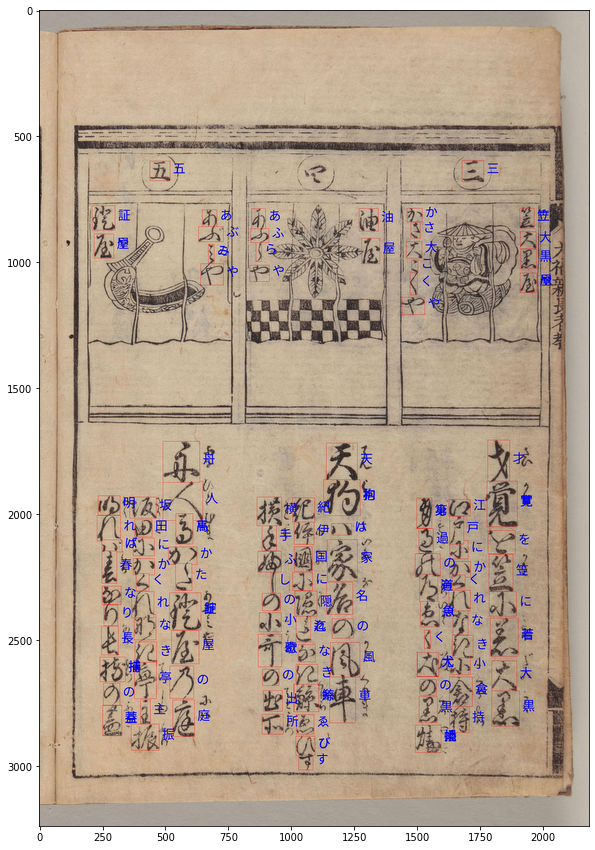

In [13]:
infer_image(0)

## Sequence Extraction

After getting bounding box coordinates and prediction labels, we want to extract text sequences from the image. We know that Ancient Japanese text is read from right to left and from top to down. However, since we have no order information from the dataset, we have to use unsupervised clustering algorithms to get the cluster. We tested the performance of two kinds of clustering algorithm: DBScan and KMeans. They group data points based on density and distance.

KMeans algorithm determines clusters first by randomly chosen k centroids in the dataset. A centroid is considered center of a cluster. Then the algorithm assigns data points to these k clusters based on the euclidean distance and update the centroid value. Therefore, choosing the number k becomes crucial in this alrorithm and we come up with an algorithm to select k automatically.

1. A large enough initial k cluster number is chosen at first. The number is estimated by twice the square root of number of characters in a page.
2. Scale y-coordinates of each character by a factor
3. Run kmeans clustering with the k number of cluster to get the centroids
4. Calculate a box with minimum x box in the page. Min y is chosen based on the scaled difference between box max y and min y.
5. Sorted centroid will check box overlap in sequence and add the centroid to a list if overlap. 
6. New cluster number is calculated by difference of previous cluster number with the number of overlap.
7. Iterate till cluster number doesn't change. usually within one or two iteration. That will be the best cluster number is used for the clustering.

We also employs DBScan algo to see its performance. It is a kind of density-based algorithm. The general procedure is listed below:

1. A point p is a core point if at least minPts points are within distance ε of it (including p).
2. A point q is directly reachable from p if point q is within distance ε from core point p. Points are only said to be directly reachable from core points.
3. A point q is reachable from p if there is a path p1, ..., pn with p1 = p and pn = q, where each pi+1 is directly reachable from pi. Note that this implies that all points on the path must be core points, with the possible exception of q.
4. All points not reachable from any other point are outliers or noise points.
5. If p is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it.

Compared to Kmeans Algorithm, it has following advantages:

1. It can detect outliers
2. It can be used to detect non-convex cluster

And disadvantages:

1. It can perform worse if the density of clusters varies largely.

Below shows the results of DBScan clustering script using maximum distance of nearest x-center as the value ε. It outputs the overall sequence from image, column cluster and proposals for characters. The graph shows labels of each character and its corresponding cluster number.

Sorted_array_num(From right to left): ['0', '3', '5', '10', '9', '4', '1', '8', '12', '11', '6', '2', '7']
Column and characters in order: {'0': [[1955.19384765625, 557.6587677001953, 'U+5FC3', 0.11650729179382324], [1955.2861328125, 557.7677459716797, 'U+3072', 0.3349383771419525], [1955.2861328125, 557.7677459716797, 'U+3074', 0.23018474876880646], [1951.6666259765625, 650.6438598632812, 'U+304F', 0.9127222299575806], [1955.5313720703125, 716.0421752929688, 'U+308B', 0.7326448559761047], [1956.1817626953125, 811.0040588378906, 'U+3057', 0.8723177313804626], [1943.1533203125, 916.2898559570312, 'U+3055', 0.8529282808303833], [1932.2373657226562, 1016.8815612792969, 'U+306B', 0.8989481329917908], [1927.5084228515625, 1113.7136840820312, 'U+4E8C', 0.948028028011322], [1927.8422241210938, 1202.0836181640625, 'U+305F', 0.8324263691902161], [1932.5297241210938, 1312.7744750976562, 'U+3073', 0.8800140619277954], [1926.0105590820312, 1432.3853149414062, 'U+4EE3', 0.9349692463874817], [1933.2

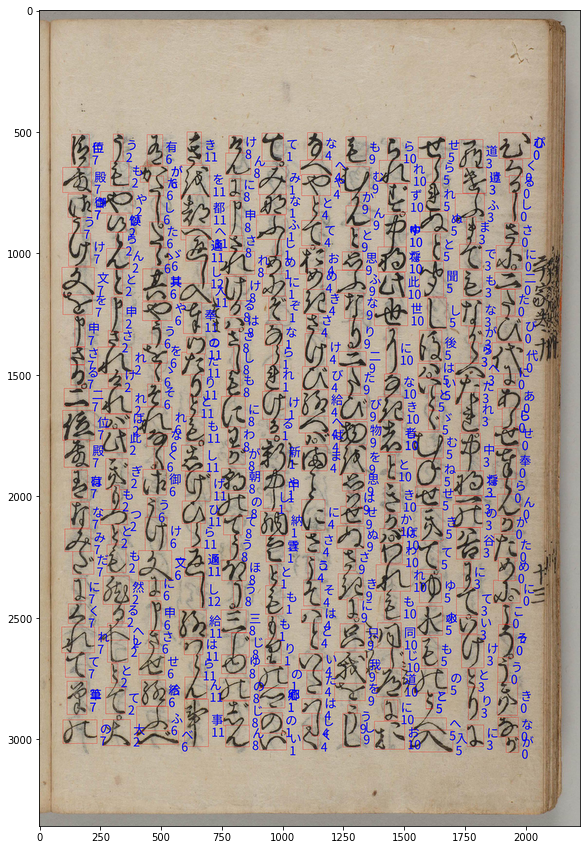

In [7]:
from mmdet.apis import init_detector, inference_detector, show_result
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import json

config = 'kaggle-kuzushiji-recognition/configs/hr32.py'
checkpoint = 'kaggle-kuzushiji-recognition/work_dirs/hr32/epoch_12.pth'
# input_image = '../data/test_images/test_2bd58b75.jpg'
input_image = 'data/test_images/test_fd9be637.jpg'

def extract_sequence(cluster_idxs, bboxes_center, labels):
    
    def get_order(x):
        return x[1] # X larger means the overall
    
    def get_first_elem(x):
        return - x[0]
    
    cluster_dict = {}
    sort_array = []
    for idx, cluster_idx in enumerate(cluster_idxs):
        if str(cluster_idx) not in cluster_dict:
            cluster_dict[str(cluster_idx)] = []
        bbox_x = bboxes_center[idx][0] # Get corresponding x-coord
        bbox_y = bboxes_center[idx][1] # Get corresponding y-coord
        char = CLASS_NAMES[labels[idx]] # Get label
        score = bboxes_center[idx][2]
        cluster_dict[str(cluster_idx)].append([bbox_x, bbox_y, char, score])
    # Sort every column using the y-coord
    for idx, cluster_idx in enumerate(cluster_dict):
        cluster_dict[str(cluster_idx)].sort(key=get_order)
        sort_array.append([cluster_dict[str(cluster_idx)][0][0], cluster_idx])
    # Get the order of columns
    sort_array.sort(key=get_first_elem)
    column_order = [elem[1] for elem in sort_array]
    print(f'Sorted_array_num(From right to left): {column_order}')
    proposals = {}
    proposed_proposals = []
    all_elems = []
    for column_num in column_order:
        last_elem = []
#         print(column_num, cluster_dict[column_num])
        for idx, elem in enumerate(cluster_dict[str(column_num)]):
            label = elem[2]
            if len(last_elem) != 0:
                dist = euclidean_distances([last_elem, elem[:2]])[0][1]
                if dist < 1:
                    if len(proposed_proposals) == 0:
                        proposed_proposals.append(idx-1)
                        label = '_' # Replace the last character with '_' since it belongs to a proposal
                        all_elems[-1] = label
                    proposed_proposals.append(idx)
                elif len(proposed_proposals) != 0: # Dist > 1 means the charcter does not belong to current proposals
                    # Write proposals
                    if column_num not in proposals:
                        proposals[str(column_num)] = []
                    proposals[str(column_num)].append(proposed_proposals)
                    proposed_proposals = []
                    all_elems.append(label)
                else:
                    all_elems.append(label) 
                # Post-process
                if idx == len(cluster_dict[str(column_num)]) - 1 and len(proposed_proposals) != 0:
                    # Write proposals
                    if column_num not in proposals:
                        proposals[str(column_num)] = []
                    proposals[str(column_num)].append(proposed_proposals)
                    proposed_proposals = []
            else:
                all_elems.append(label)
            last_elem = elem[:2]
    print(f'Column and characters in order: {cluster_dict}')
    print(f'Proposals by index: {proposals}')
    print(f'All Elems: {all_elems}')
    return all_elems, cluster_dict, proposals
            
def cluster(X, eps):
    clusters = DBSCAN(eps=eps, min_samples=1).fit_predict(X)
    return clusters


def main():
    model = init_detector(config, checkpoint, device='cuda:0')
    path = '/'.join(input_image.split('/')[:-1])
    for idx, f in enumerate(listdir(path)):
        filename = join(path, f)
        if isfile(filename):
            result = inference_detector(model, filename)
            result = result[:-1]
            if isinstance(result, tuple):
                bbox_result, segm_result = result
            else:
                bbox_result, segm_result = result, None    
            bboxes = np.vstack(bbox_result)
            bboxes_center = np.zeros((bboxes.shape[0], 3))
            bboxes_x = np.zeros((bboxes.shape[0], 1))
            bboxes_xy = np.zeros((bboxes.shape[0], 2))
            if len(bboxes) != 0:
                for idx, bbox in enumerate(bboxes):
                    bboxes_center[idx] = [(bbox[2]-bbox[0])/2+bbox[0], (bbox[3]-bbox[1])/2+bbox[1], bbox[4]]
                    bboxes_x[idx] = [(bbox[0] + bbox[2])/2]
                distances = euclidean_distances(bboxes_x)
                distances.sort(axis=1)
                smallest_dist = []
                for distance in distances:
                    try:
                        smallest_dist.append(distance[np.where(distance > 1)][0])
                    except:
                        smallest_dist.append(1)
                eps = np.max(smallest_dist)
                clusters = cluster(bboxes_x, eps)
                labels = [
                    np.full(bbox.shape[0], i, dtype=np.int32)
                    for i, bbox in enumerate(bbox_result)
                ]
                labels = np.concatenate(labels)
                all_elems, cluster_dict, proposals = extract_sequence(clusters, bboxes_center, labels)
            else:
                all_elems = {}
                cluster_dict = {}
                proposals = {}
            with open(f'{join("data/test_jsons",f.split(".")[0])}.json', "w") as f:
                f.write(json.dumps({
                    "all_elems": all_elems,
                    "cluster_dict": cluster_dict,
                    "proposals": proposals
                }))
            viz = visualize_training_data(filename, bboxes, labels, clusters)
            plt.figure(figsize=(15, 15))
            plt.imshow(viz, interpolation='lanczos')
            plt.show()
            break
    
main()